In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import emoji
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [47]:
data_path = 'review_app_titipku.csv'

In [48]:
df = pd.read_csv(data_path)
df.head()

,source,review_id,user_name,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,review_title
0,Google Play,a9e7630f-01df-41d5-b20a-3936629ad0f1,Wandi Bae,Semoga bermanfaat,4,0.0,2024-07-21 23:47:11,Terima kasih banyak sudah mendukung Jatiper da...,2024-07-22 13:33:50,2.38.0,NaN
1,Google Play,3904a233-c1ca-44c5-a4b4-cd247d6826ad,Neni Arumi,Sangat membantu dalam menyelesaikan masalah sa...,5,0.0,2024-07-09 09:59:54,Terima kasih banyak sudah mendukung Jatiper da...,2024-07-09 10:08:30,2.38.0,NaN
2,Google Play,d830b029-1fbe-4280-8688-2f21957a17d4,NurulL,Kapan ada di Surabaya ya,4,0.0,2024-07-09 06:29:39,Mohon maaf sekalu kak Nurul saat ini Titipku b...,2024-07-09 10:07:37,NaN,NaN
3,Google Play,99ba8091-49ee-45c8-a7e7-c5e80c900171,aditiya auliya,"Tolong dong, Invasi ke Lampung juga, dsini mul...",5,2.0,2024-07-07 21:27:48,Terima kasih banyak atas saran dan masukannya ...,2024-07-09 10:06:32,2.39.1,NaN
4,Google Play,fb91c7d2-4ea4-4cb7-9759-27e525c454f6,Rina S,Terimakasih titipku..TitipanKu sesuai mauku da...,5,3.0,2024-07-07 19:53:11,Terima kasih banyak atas dukungan yang diberik...,2024-07-09 10:05:09,2.39.1,NaN


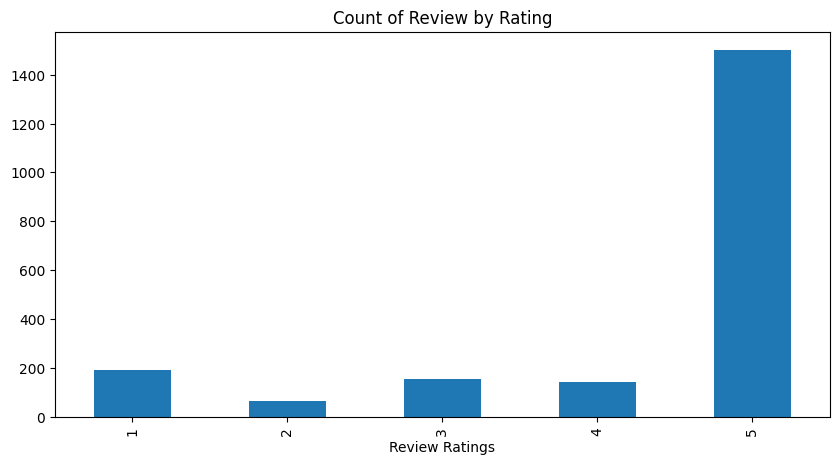

In [49]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title="Count of Review by Rating",
          figsize=(10,5))
ax.set_xlabel('Review Ratings')
plt.show()

In [50]:
print(f'shape: {df.shape}')

shape: (2052, 11)


In [51]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Create stopword remover
stop_factory = StopWordRemoverFactory()
reduce_word = ['tidak']
stopwords_indonesian = stop_factory.get_stop_words() + ['titipku']
stopwords_indonesian = list(filter(lambda x:x not in reduce_word, stopwords_indonesian))

In [52]:
replacements = {
    'yg': 'yang',
    'dgn': 'dengan',
    'jd': 'jadi',
    'tdk': 'tidak',
    'ga': 'tidak',
    'mager': 'malas',
    'gua': 'aku',
    'nggak': 'tidak',
    'dlm': 'dalam',
    'utk': 'untuk',
    'trs': 'terus',
    'trus': 'terus',
    'kyk': 'seperti',
    'bgt': 'banget',
    'apk': 'aplikasi',
    'krna': 'karena',
    'byk': 'banyak',
    'knp': 'kenapa',
    'sm': 'sama',
    'tmn': 'teman',
    'brg': 'barang',
    'dr': 'dari',
    'sy': 'saya',
    'kl': 'kalau',
    'brp': 'berapa',
    'bsk': 'besok',
    'udh': 'sudah',
    'blm': 'belum',
    'cmn': 'cuman',
    'td': 'tadi',
    'kpn': 'kapan',
    'spt': 'seperti',
    'bljr': 'belajar',
    'skrg': 'sekarang',
    'org': 'orang',
    'lh': 'lah',
    'gt': 'gitu',
    'trs': 'terus',
    'bkn': 'bukan',
    'jg': 'juga',
    'mn': 'mana',
    'bbrp': 'beberapa',
    'sj': 'saja',
    'skr': 'sekarang',
    'blg': 'bilang',
    'mnt': 'minta',
    'gmna': 'gimana',
    'plg': 'paling',
    'krn': 'karena',
    'sbg': 'sebagai',
    'bs': 'bisa',
    'smg': 'semoga',
    'lbh': 'lebih',
    'dpn': 'depan',
    'tlg': 'tolong',
    'pd': 'pada',
    'hrs': 'harus',
    'lgs': 'langsung',
    'ptg': 'penting',
    'ank': 'anak',
    'sm2': 'sama-sama',
    'smua': 'semua',
    'ngga': 'tidak',
    'bgt': 'banget',
    'gpp': 'tidak apa-apa',
    'ny': 'nya',
    'dl': 'dulu',
    'ad': 'ada',
    'aj': 'aja',
    'jgn': 'jangan',
    'dri': 'dari',
    'mkn': 'makan',
    'n': 'dan',
    'bnr': 'benar',
    'ntar': 'nanti',
    'ak': 'aku',
    'y': 'ya',
    'ngapain': 'mengapa',
    'buat': 'untuk',
    'sgt': 'sangat'
}

def replace_words(text, replacements):
    for old, new in replacements.items():
        text = re.sub(r'\b' + re.escape(old) + r'\b', new, text)
    return text
    
df['review_description'] = df['review_description'].apply(lambda x: replace_words(x, replacements))

In [53]:
def clean_review(review):
  review = emoji.replace_emoji(review, replace='')
  review = re.sub(r'\@w+|\#', '', review)
  review = re.sub(r'[^A-Za-z\s]', '', review)
  review = re.sub(r'\s+', ' ', review).strip()
  review = review.lower()
  tokens = word_tokenize(review)
  tokens = [word for word in tokens if word not in stopwords_indonesian]
  lemmatized_words = [stemmer.stem(word) for word in tokens]

  return ' '.join(lemmatized_words)

In [54]:
pretrained= "mdhugol/indonesia-bert-sentiment-classification"

model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [55]:
df['clean_text'] = df.apply(lambda x: clean_review(x['review_description']), axis=1)

In [56]:
df.head()

,source,review_id,user_name,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,review_title,clean_text
0,Google Play,a9e7630f-01df-41d5-b20a-3936629ad0f1,Wandi Bae,Semoga bermanfaat,4,0.0,2024-07-21 23:47:11,Terima kasih banyak sudah mendukung Jatiper da...,2024-07-22 13:33:50,2.38.0,NaN,moga manfaat
1,Google Play,3904a233-c1ca-44c5-a4b4-cd247d6826ad,Neni Arumi,Sangat membantu dalam menyelesaikan masalah sa...,5,0.0,2024-07-09 09:59:54,Terima kasih banyak sudah mendukung Jatiper da...,2024-07-09 10:08:30,2.38.0,NaN,sangat bantu selesai masalah sayur mayur dagin...
2,Google Play,d830b029-1fbe-4280-8688-2f21957a17d4,NurulL,Kapan ada di Surabaya ya,4,0.0,2024-07-09 06:29:39,Mohon maaf sekalu kak Nurul saat ini Titipku b...,2024-07-09 10:07:37,NaN,NaN,kapan surabaya
3,Google Play,99ba8091-49ee-45c8-a7e7-c5e80c900171,aditiya auliya,"Tolong dong, Invasi ke Lampung juga, dsini mul...",5,2.0,2024-07-07 21:27:48,Terima kasih banyak atas saran dan masukannya ...,2024-07-09 10:06:32,2.39.1,NaN,dong invasi lampung dsini mulai ramai pasar jd...
4,Google Play,fb91c7d2-4ea4-4cb7-9759-27e525c454f6,Rina S,Terimakasih titipku..TitipanKu sesuai mauku da...,5,3.0,2024-07-07 19:53:11,Terima kasih banyak atas dukungan yang diberik...,2024-07-09 10:05:09,2.39.1,NaN,terimakasih titipkutitipanku sesuai mau engkau...


In [57]:
label_index = {'LABEL_0': 'Positive', 'LABEL_1': 'Neutral', 'LABEL_2': 'Negative'}

data = (
    df
    .assign(sentiment = lambda x:x['clean_text'].apply(lambda s : sentiment_classifier(s)))
    .assign(
        label = lambda x : x['sentiment'].apply(lambda s:label_index[s[0]['label']]),
        score = lambda x : x['sentiment'].apply(lambda s:s[0]['score'])
    )
)

In [58]:
data.head()

,source,review_id,user_name,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,review_title,clean_text,sentiment,label,score
0,Google Play,a9e7630f-01df-41d5-b20a-3936629ad0f1,Wandi Bae,Semoga bermanfaat,4,0.0,2024-07-21 23:47:11,Terima kasih banyak sudah mendukung Jatiper da...,2024-07-22 13:33:50,2.38.0,NaN,moga manfaat,"[{'label': 'LABEL_0', 'score': 0.9865277409553...",Positive,0.986528
1,Google Play,3904a233-c1ca-44c5-a4b4-cd247d6826ad,Neni Arumi,Sangat membantu dalam menyelesaikan masalah sa...,5,0.0,2024-07-09 09:59:54,Terima kasih banyak sudah mendukung Jatiper da...,2024-07-09 10:08:30,2.38.0,NaN,sangat bantu selesai masalah sayur mayur dagin...,"[{'label': 'LABEL_1', 'score': 0.9525430798530...",Neutral,0.952543
2,Google Play,d830b029-1fbe-4280-8688-2f21957a17d4,NurulL,Kapan ada di Surabaya ya,4,0.0,2024-07-09 06:29:39,Mohon maaf sekalu kak Nurul saat ini Titipku b...,2024-07-09 10:07:37,NaN,NaN,kapan surabaya,"[{'label': 'LABEL_1', 'score': 0.4880608320236...",Neutral,0.488061
3,Google Play,99ba8091-49ee-45c8-a7e7-c5e80c900171,aditiya auliya,"Tolong dong, Invasi ke Lampung juga, dsini mul...",5,2.0,2024-07-07 21:27:48,Terima kasih banyak atas saran dan masukannya ...,2024-07-09 10:06:32,2.39.1,NaN,dong invasi lampung dsini mulai ramai pasar jd...,"[{'label': 'LABEL_0', 'score': 0.9477875828742...",Positive,0.947788
4,Google Play,fb91c7d2-4ea4-4cb7-9759-27e525c454f6,Rina S,Terimakasih titipku..TitipanKu sesuai mauku da...,5,3.0,2024-07-07 19:53:11,Terima kasih banyak atas dukungan yang diberik...,2024-07-09 10:05:09,2.39.1,NaN,terimakasih titipkutitipanku sesuai mau engkau...,"[{'label': 'LABEL_0', 'score': 0.9889184832572...",Positive,0.988918


In [59]:
data['label'].value_counts()

label
Positive    1414
Negative     345
Neutral      293
Name: count, dtype: int64

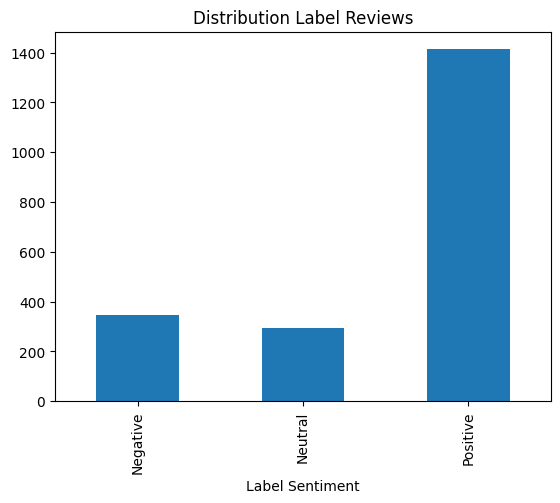

In [60]:
ax = data['label'].value_counts().sort_index() \
    .plot(kind='bar', title='Distribution Label Reviews')
ax.set_xlabel('Label Sentiment')
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5732\2419402819.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


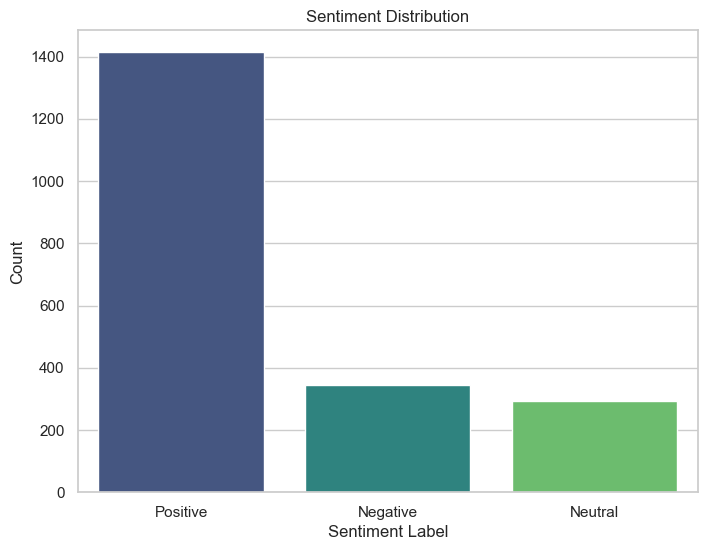

In [61]:
import seaborn as sns

sentiment_counts = data['label'].value_counts()

# Plot a distribution
# st.set_option('deprecation.showPyplotGlobalUse', False)
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
# st.pyplot()
plt.show()

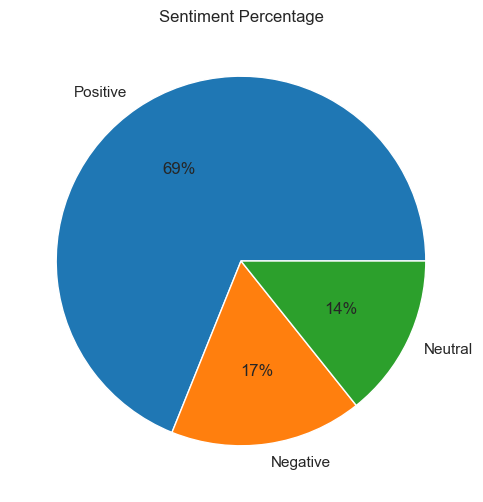

In [62]:
sentiment_counts = data['label'].value_counts()
# palette = sns.color_palette("tab10")
palette = sns.color_palette("tab10", len(sentiment_counts))

# sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, colors=palette, autopct='%.0f%%')
plt.title("Sentiment Percentage")
plt.show()

In [63]:
sentiment_counts.index

Index(['Positive', 'Negative', 'Neutral'], dtype='object', name='label')

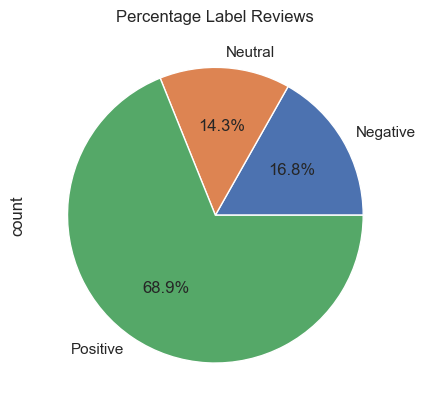

In [64]:
data['label'].value_counts().sort_index() \
  .plot(kind='pie', autopct='%1.1f%%', title='Percentage Label Reviews')
plt.show()

In [65]:
data.to_csv('labeled_data.csv', index=False)

In [66]:
from wordcloud import WordCloud

def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color ='white', stopwords = None, min_font_size = 10).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

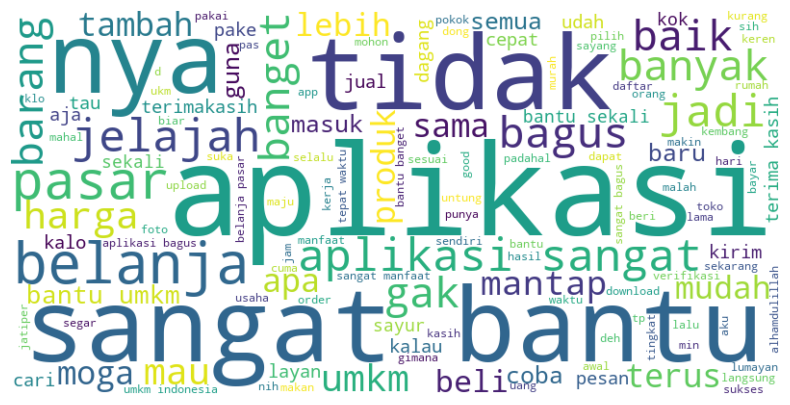

In [67]:
text = data['clean_text'].str.cat(sep=' ')
generate_wordcloud(text)

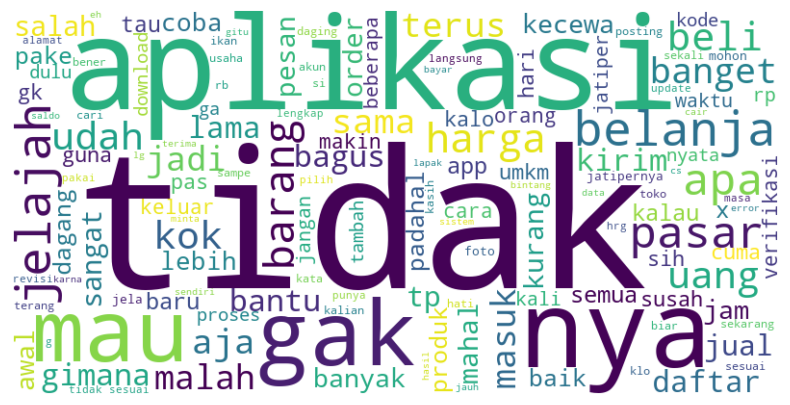

In [68]:
text_negative = data[data['label']=='Negative']
text_negative = text_negative['clean_text'].str.cat(sep=' ')
generate_wordcloud(text_negative)

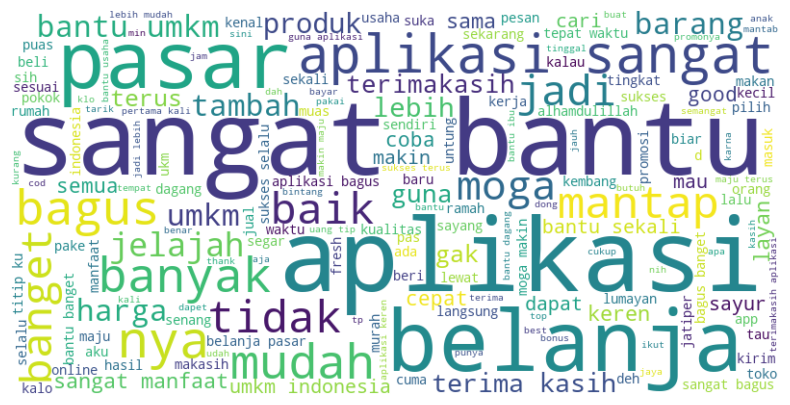

In [69]:
text_positive = data[data['label']=='Positive']
text_positive = text_positive['clean_text'].str.cat(sep=' ')
generate_wordcloud(text_positive)